## CONTENTS 

1. Import Libraries  
2. Upload Data Sets 
3. Data Checks \ 
  a. LARGE DATAFRAME \
  b. DEPARTMENTS DATATFRAME 
4. ADDRESS PII 
5. CREATE REGIONAL FLAGS
6. EXPLORE SPENDING HABITS IN REGIONS
7. EXPLORE CUSTOMER DATA 
8. CREATE CUSTOMER PROFILES
9. EXPORT THE DATAFRAMES 

### 1. IMPORT LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

### 2. UPLOAD DATA SETS

In [3]:
path = r'/Users/biancaskyehoney/Documents/Instacart Basket Analysis '

In [4]:
# Large merged df file path specified 
pickle_file_path = os.path.join(path, '02 Data', 'Prepared Data', 'ords_prods_cust_merged.pkl')

# Read the Pickle file (large df) using pd.read_pickle()
df = pd.read_pickle(pickle_file_path)

In [5]:
# Departments file path 

df_departments = pd.read_csv(os.path.join(path, '02 Data', 'prepared data', 'departments_wrangled.csv'), index_col=0)

#### Data checks - Large df 

In [6]:
df.shape

(32404859, 37)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32404859 entries, 0 to 32404858
Data columns (total 37 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int64   
 1   user_id                 int64   
 2   order_number            int64   
 3   orders_day_of_week      int64   
 4   order_hour_of_day       int64   
 5   days_since_prior_order  float64 
 6   first_order             int64   
 7   product_id              int64   
 8   add_to_cart_order       int64   
 9   reordered               int64   
 10  product_name            object  
 11  aisle_id                int64   
 12  department_id           int64   
 13  prices                  float64 
 14  _merge                  category
 15  price_range_loc         object  
 16  busiest day             object  
 17  day_category            object  
 18  slowest_days            bool    
 19  busiest_days            object  
 20  busiest_period_of_day   object  
 21  max_or

In [8]:
df.head(5)

,order_id,user_id,order_number,orders_day_of_week,order_hour_of_day,days_since_prior_order,first_order,product_id,add_to_cart_order,reordered,...,frequency_flag,first_name,surname,gender,state,age,date_joined,n_dependants,fam_status,income
0,2539329,1,1,2,8,NaN,1,196,1,0,...,Non-frequent customer,Linda,Nguyen,Female,Alabama,31,2/17/2019,3,married,40423
1,2398795,1,2,3,7,15.0,0,196,1,1,...,Non-frequent customer,Linda,Nguyen,Female,Alabama,31,2/17/2019,3,married,40423
2,473747,1,3,3,12,21.0,0,196,1,1,...,Non-frequent customer,Linda,Nguyen,Female,Alabama,31,2/17/2019,3,married,40423
3,2254736,1,4,4,7,29.0,0,196,1,1,...,Non-frequent customer,Linda,Nguyen,Female,Alabama,31,2/17/2019,3,married,40423
4,431534,1,5,4,15,28.0,0,196,1,1,...,Non-frequent customer,Linda,Nguyen,Female,Alabama,31,2/17/2019,3,married,40423


### 3. Data Checks

#### Data checks _ departments df 

In [9]:
df_departments.shape

(21, 1)

In [10]:
df_departments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 1 to 21
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   department  21 non-null     object
dtypes: object(1)
memory usage: 336.0+ bytes


In [11]:
df_departments.head()

,department
1,frozen
2,other
3,bakery
4,produce
5,alcohol


#### Merge datasets 

In [12]:
# Merge departments names into large datafram 

df = df.merge(df_departments, how = 'inner', left_on ='department_id', right_index = True)

In [13]:
df [['product_id', 'department_id', 'department']].head()

,product_id,department_id,department
0,196,7,beverages
1,196,7,beverages
2,196,7,beverages
3,196,7,beverages
4,196,7,beverages


### 4. Address PII concerns 

#### Name and Surname are the only identifiable data points that could potentially be probelmatic. What to solve: Either could mask this data or drop this data as it could save on RAM - this data is not pertinent to analysis - user_id would suffice

In [14]:
# Drop Name & Surname Columns 

df_2 = df.drop(columns = ['first_name','surname'])

#### Create additional columns and flags necessary for anlaysis 

In [15]:
#Create a column that shows total order value per order, per user 

df_2['total_order_cost'] = df.groupby('order_id')['prices'].transform('sum')

In [16]:
#check

df_2[['user_id','order_id','total_order_cost']].head(5)    

,user_id,order_id,total_order_cost
0,1,2539329,31.6
1,1,2398795,35.4
2,1,473747,28.2
3,1,2254736,26.0
4,1,431534,57.0


In [17]:
# Create a column that shows number of products in order cart 

df_2['num_prod_per_order'] = df.groupby('order_id')['add_to_cart_order'].transform('max')

In [18]:
# Check 

df_2[['order_id','num_prod_per_order','total_order_cost']].head(5)

,order_id,num_prod_per_order,total_order_cost
0,2539329,5,31.6
1,2398795,6,35.4
2,473747,5,28.2
3,2254736,5,26.0
4,431534,8,57.0


In [19]:
# create a column that lists the average price per product per user

df_2['avg_prod_price'] = df.groupby('user_id')['prices'].transform('mean')

In [20]:
# create a column that lists the average order cost for each customer

a = df_2.groupby(['user_id','order_number'])['prices'].sum().to_frame()
b = a.groupby('user_id')['prices'].mean().rename('avg_order_cost')
df_2 = df_2.merge(b, how='left', on='user_id')

### 5. Create regional flags 

In [21]:
# Create regions based on states 

northeast = ['Maine','New Hampshire', 'Vermont', 'Massachusetts','Rhode Island',
             'Connecticut','New York','Pennsylvania','New Jersey']

midwest = ['Wisconsin','Michigan','Illinois','Indiana','Ohio','North Dakota','South Dakota',
           'Nebraska','Kansas','Minnesota','Iowa','Missouri']

south = ['Delaware','Maryland','District of Columbia','Virginia','West Virginia','North Carolina',
         'South Carolina','Georgia','Florida','Kentucky','Tennessee','Mississippi','Alabama','Oklahoma',
         'Texas','Arkansas','Louisiana']

west = ['Idaho', 'Montana', 'Wyoming', 'Nevada', 'Utah', 'Colorado', 'Arizona','New Mexico', 'Alaska', 
        'Washington', 'Oregon', 'California', 'Hawaii']

In [22]:
# Create statement to id new region column

df_2.loc[df_2['state'].isin(northeast), 'region'] = 'northeast'

In [23]:
df_2.loc[df_2['state'].isin(midwest), 'region'] = 'midwest'

In [24]:
df_2.loc[df_2['state'].isin(south), 'region'] = 'south'

In [25]:
df_2.loc[df_2['state'].isin(west), 'region'] = 'west'

In [26]:
# Check statements 

df_2['region'].value_counts(dropna=False)

south        10791885
west          8292913
midwest       7597325
northeast     5722736
Name: region, dtype: int64

### 6. Explore spending habits amongst regions

In [27]:
region_spending_avg = df_2.groupby(['region', 'spending_flag'])['prices'].mean().reset_index()


In [28]:
pivot_table = region_spending_avg.pivot(index= 'region', columns='spending_flag', values='prices')


In [29]:
pivot_table

spending_flag,High spender,Low spender
region,,
midwest,248.080653,7.782093
northeast,207.709477,7.773935
south,234.822523,7.784123
west,190.868148,7.779584


In [30]:
# Determine difference in a spending habits between regions 

df_region = df_2[['region', 'order_id', 'avg_order_cost', 'avg_prod_price', 'prices', 'total_order_cost', 'user_id']].groupby('region').agg({
    'order_id': pd.Series.nunique,
    'user_id': pd.Series.nunique,   # Count of unique user_ids per region
    'avg_order_cost': 'mean',      # Mean of avg_order_cost
    'avg_prod_price': 'mean',      # Mean of avg_prod_price
    'prices': 'sum',               # Total order value per region
    'total_order_cost': 'max'      # Max order value per order in each region
}).sort_values(by='order_id', ascending=False)


In [31]:
df_region

,order_id,user_id,avg_order_cost,avg_prod_price,prices,total_order_cost
region,,,,,,
south,1071562,68737,159.532955,12.195577,131613265.4,100452.9
west,821686,52565,151.335532,11.319834,93874398.7,100384.5
midwest,754275,48519,170.541268,12.715483,96603658.7,100403.8
northeast,567162,36388,154.533748,11.554997,66126199.8,100322.1


####
Spending is higher in the South in terms of total amount spents however, average order cost is higher in the midwest
#### 
Indicates that there are more customers in the south, however midwest holds a lot of weight in terms of order value and power 

#### Create a df that summarizes this data 

In [32]:
# Rename above columns to avoid confusion

df_region = df_region.rename(columns={'prices':'prices_sum', 'user_id':'user_count','order_id': 'order_count'})


In [33]:
# create calculated columns based on the aggregated data
df_region['price_per_order'] = df_region['prices_sum']/df_region['order_count']
df_region['price_per_user'] = df_region['prices_sum']/df_region['user_count']
df_region['order_per_user'] = df_region['order_count']/df_region['user_count']

In [34]:
df_region

,order_count,user_count,avg_order_cost,avg_prod_price,prices_sum,total_order_cost,price_per_order,price_per_user,order_per_user
region,,,,,,,,,
south,1071562,68737,159.532955,12.195577,131613265.4,100452.9,122.823752,1914.736829,15.589304
west,821686,52565,151.335532,11.319834,93874398.7,100384.5,114.246073,1785.872704,15.631808
midwest,754275,48519,170.541268,12.715483,96603658.7,100403.8,128.074852,1991.048016,15.545972
northeast,567162,36388,154.533748,11.554997,66126199.8,100322.1,116.591379,1817.252935,15.586512


### 7. Exploring Customer data

#### Create an exclusion flag for low-activity customers (customers with less than 5 orders) and exclude them from the data.

In [35]:
df_2.loc[df_2['max_order'] < 5, 'exclusion'] = 1

In [36]:
df_2.loc[df_2['max_order'] >= 5, 'exclusion'] = 0

In [37]:
#check results

df_2['exclusion'].value_counts(dropna = False)

0.0    30964564
1.0     1440295
Name: exclusion, dtype: int64

In [38]:
# Filter the DataFrame to select rows where 'max_order' is less than 5
sample_df = df_2[df_2['max_order'] < 5]

In [39]:
# Export the sample DataFrame to a CSV file

sample_df.to_csv(os.path.join(path, '02 Data', 'Prepared Data', 'sample_max_order_lt_5.csv'), index=False)

### 8. Create Customer Profiling 

In [40]:
# create a df that just lists customers

customers = df_2.drop_duplicates(subset=['user_id'])

In [41]:
customers.shape

(206209, 42)

#### Age ranges for customers

In [42]:
# Find the maximum income
max_income = df_2['income'].max()


# Find the minimum income
min_income = df['income'].min()

In [43]:
max_income

593901

In [44]:
min_income

25903

#### Create customer profiles based on age and income

In [45]:
# Define criteria for customer profiles

# Define age bins and labels
bins_age = [0, 25, 35, 45, 55, float('inf')]
labels_age = ['Young Adult', 'Adult', 'Middle-aged', 'Senior Adult', 'Senior']

# Define income bins and labels
bins_income = [0, 30000, 45000, 75000, 100000, float('inf')]
labels_income = ['Low Income', 'Lower-Middle Income', 'Middle Income', 'Upper-Middle Income', 'High Income']

In [46]:
# Create profiling variables based on age and income

df_2['age_profile'] = pd.cut(df_2['age'], bins=bins_age, labels=labels_age)
df_2['income_profile'] = pd.cut(df_2['income'], bins=bins_income, labels=labels_income)



In [47]:
df_2.head(5)

,order_id,user_id,order_number,orders_day_of_week,order_hour_of_day,days_since_prior_order,first_order,product_id,add_to_cart_order,reordered,...,income,department,total_order_cost,num_prod_per_order,avg_prod_price,avg_order_cost,region,exclusion,age_profile,income_profile
0,2539329,1,1,2,8,NaN,1,196,1,0,...,40423,beverages,31.6,5,6.367797,37.57,south,0.0,Adult,Lower-Middle Income
1,2398795,1,2,3,7,15.0,0,196,1,1,...,40423,beverages,35.4,6,6.367797,37.57,south,0.0,Adult,Lower-Middle Income
2,473747,1,3,3,12,21.0,0,196,1,1,...,40423,beverages,28.2,5,6.367797,37.57,south,0.0,Adult,Lower-Middle Income
3,2254736,1,4,4,7,29.0,0,196,1,1,...,40423,beverages,26.0,5,6.367797,37.57,south,0.0,Adult,Lower-Middle Income
4,431534,1,5,4,15,28.0,0,196,1,1,...,40423,beverages,57.0,8,6.367797,37.57,south,0.0,Adult,Lower-Middle Income


In [48]:
# Check to see if criteria in action

# Define the criteria for the subset
young_adult_low_income = df_2[(df_2['age_profile'] == 'Young Adult') & (df_2['income_profile'] == 'Low Income')]

# Group the subset by user_id and include the 'age' and 'income' columns
young_adult_table = young_adult_low_income.groupby('user_id').agg({'age': 'first', 'income': 'first'}).reset_index()

# View the table
print(young_adult_table)

     user_id  age  income
0        308   22   27467
1        598   21   26576
2        909   18   29258
3       1087   19   29005
4       1342   24   28806
..       ...  ...     ...
645   203827   22   28823
646   204250   22   29956
647   204256   24   27476
648   204329   19   25972
649   205480   19   26219

[650 rows x 3 columns]


#### Create visualisation based on age bins

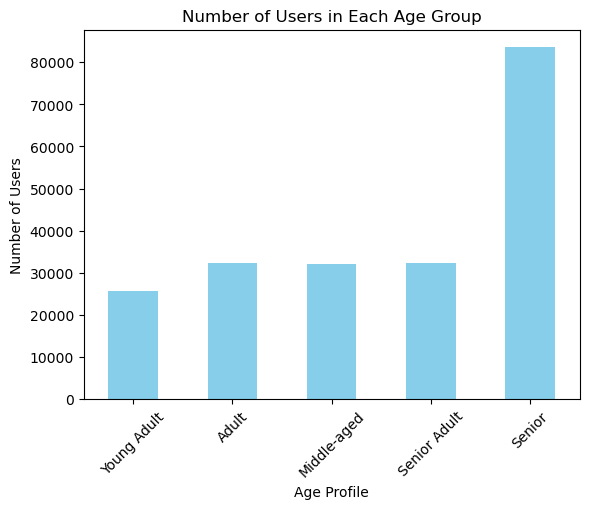

In [49]:
# Count the number of users in each age group (remove duplicates)
age_group_counts = df_2.drop_duplicates(subset=['user_id'])['age_profile'].value_counts().reindex(labels_age, fill_value=0)

# Create a bar graph
age_group_counts_bar = age_group_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Age Profile')
plt.ylabel('Number of Users')
plt.title('Number of Users in Each Age Group')
plt.xticks(rotation=45)
plt.show()

In [70]:
#export the visualization 
age_group_counts_bar.figure.savefig(os.path.join(path, '04 Analysis','Visualisations', 'age_group_counts_bar.png'), bbox_inches='tight')

### Create vis based on income brackets

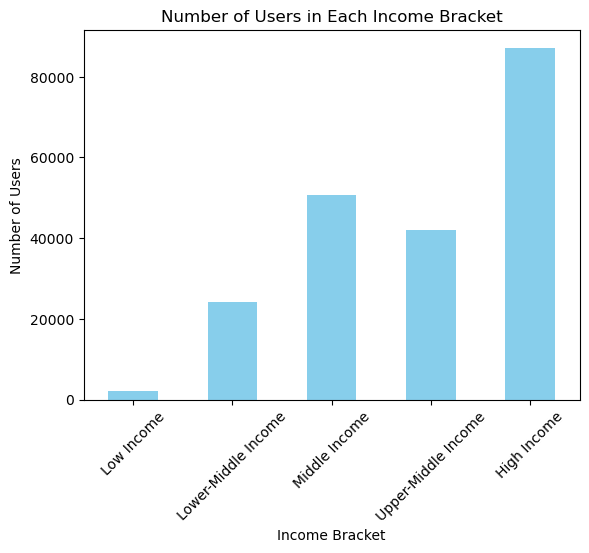

In [51]:
# Count the number of users in each income bracket (remove duplicates)
income_bracket_counts = df_2.drop_duplicates(subset=['user_id'])['income_profile'].value_counts().reindex(labels_income, fill_value=0)

# Create a bar graph
income_bracket_counts_bar = income_bracket_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Income Bracket')
plt.ylabel('Number of Users')
plt.title('Number of Users in Each Income Bracket')
plt.xticks(rotation=45)
plt.show()

In [71]:
#export the visualization 
income_bracket_counts_bar.figure.savefig(os.path.join(path, '04 Analysis','Visualisations', 'income_bracket_counts_bar.png'), bbox_inches='tight')

### Customer Profiles - Personas

### Family Shoppers:

Profile Criteria: Customers with a high number of dependents who purchase from the "baby" and "pantry" departments.
Description: This profile includes families with young children who buy baby-related products and pantry staples.

In [53]:
# Create a new column for the "Family Shoppers" profile

df_2['profile_family_shopper'] = (df_2['n_dependants'] >= 1) & ((df_2['department'] == 'babies'))

In [54]:
# Filter the DataFrame to find customers with the "Family Shoppers" profile

family_shoppers = df_2[df_2['profile_family_shopper']]

In [55]:
#Check output

family_shoppers = df_2[df_2['profile_family_shopper'] == True]

### Pet Owners:

Profile Criteria: Customers who purchase items from the "pets" department.

Description: This profile represents pet owners who buy pet-related products.

In [56]:
# Create a new column for the "Pet Owners" profile
df_2['profile_pet_owner'] = (df_2['department'] == 'pets')

# Filter the DataFrame to find customers with the "Pet Owners" profile
pet_owners = df_2[df_2['profile_pet_owner']]


pet_owners = df_2[df_2['profile_pet_owner'] == True]

### Late-Night Shoppers:

Profile Criteria: Customers who shop during late hours (e.g., after 8 PM) based on the "order_hour_of_day" column.
Description: This profile includes customers who prefer shopping during late-night hours.

In [57]:
# Create a new column for the "Late-Night Shoppers" profile
df_2['profile_late_night_shopper'] = (df_2['order_hour_of_day'] > 20)

# Filter the DataFrame to find customers with the "Late-Night Shoppers" profile
late_night_shoppers = df_2[df_2['profile_late_night_shopper']]


### Bulk Shoppers:

Profile Criteria: Customers who buy items in bulk from the "bulk" department.
Description: This profile represents customers who prefer purchasing in larger quantities.

In [58]:
# Create a new column for the "Bulk Shoppers" profile

df_2['profile_bulk_shopper'] = (df_2['department'] == 'bulk')

# Filter the DataFrame to find customers with the "Bulk Shoppers" profile

bulk_shoppers = df_2[df_2['profile_bulk_shopper']]

### Weekend Shoppers:

Profile Criteria: Customers who tend to shop on weekends (based on "orders_day_of_week" and "order_hour_of_day" columns).
Description: This profile captures customers who do their grocery shopping primarily on weekends.

In [59]:
# Create a new column for the "Weekend Shoppers" profile
df_2['profile_weekend_shopper'] = ((df_2['orders_day_of_week'] == 0) | (df_2['orders_day_of_week'] == 1))

# Filter the DataFrame to find customers with the "Weekend Shoppers" profile
weekend_shoppers = df_2[df_2['profile_weekend_shopper']]

### Health Enthusiasts:

Profile Criteria: Customers who purchase a significant number of items from the "produce," "meat seafood," and "dairy eggs" departments.
Description: This profile represents customers who prioritize fresh and healthy food choices.

In [60]:
# Create a new column for the "Health Enthusiasts" profile
df_2['profile_health_enthusiast'] = (
    (df_2['department'].isin(['produce', 'meat seafood', 'dairy eggs','breakfast'])))

# Filter the DataFrame to find customers with the "Health Enthusiasts" profile
health_enthusiasts = df_2[df_2['profile_health_enthusiast']]

### Convenience Shoppers:

Profile Criteria: Customers who frequently purchase items from the "frozen," "canned goods," and "snacks" departments.
Description: This profile includes customers who prefer convenient and easy-to-prepare food options.

In [61]:
# Create a new column for the "Convenience Shoppers" profile
df_2['profile_convenience_shopper'] = (
    df_2['department'].isin(['frozen', 'canned goods', 'snacks']))

# Filter the DataFrame to find customers with the "Convenience Shoppers" profile
convenience_shoppers = df_2[df_2['profile_convenience_shopper']]


### Gourmet Foodies:

Profile Criteria: Customers who buy specialty items from the "international" and "deli" departments.
Description: This profile represents customers who enjoy exploring and indulging in gourmet and international cuisine.

In [62]:
# Create a new column for the "Gourmet Foodies" profile
df_2['profile_gourmet_foodie'] = (
    df_2['department'].isin(['international', 'deli']))

# Filter the DataFrame to find customers with the "Gourmet Foodies" profile
gourmet_foodies = df_2[df_2['profile_gourmet_foodie']]

### Single Adult:

Prodile Criteria: Customers who are considered to be legal adults (18+) without any dependants. 
Description: This profile represents customers who are considered adults and therefore have buying power but do not need to consider dependants. 

In [63]:
# Create a 'Single Adult' label based on age and number of dependants
df_2['profile_single_adult'] = (
    (df_2['age'] > 18)  # Age is above 18
    & (df_2['n_dependants'] == 0)  # No dependants
)

# Check the counts of 'Single Adult' profiles
single_adult_count = df_2['profile_single_adult'].sum()
print(f"Number of 'Single Adult' profiles: {single_adult_count}")

Number of 'Single Adult' profiles: 7972187


####  Vis to represent the cusotmer categories 

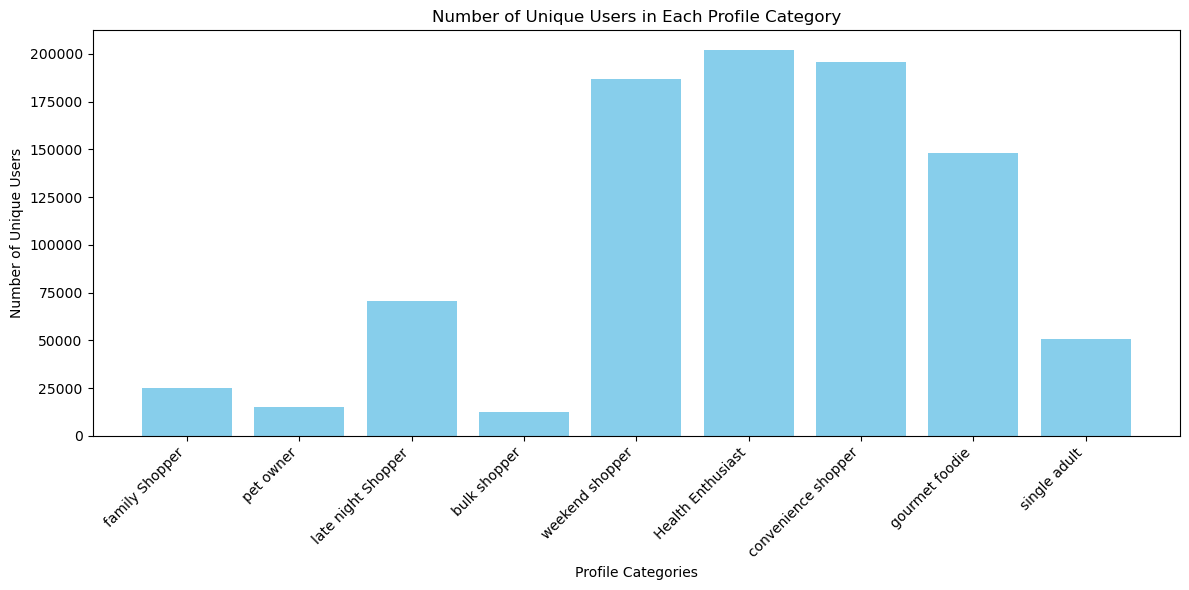

In [64]:
# Define a list of profile categories
profile_categories = [
    'family Shopper', 'pet owner', 'late night Shopper',
    'bulk shopper', 'weekend shopper', 'Health Enthusiast',
    'convenience shopper', 'gourmet foodie', 'single adult']

# Count the number of unique users in each profile category
user_counts = []

for category in profile_categories:
    profile_column_name = f'profile_{category.replace(" ", "_").lower()}'
    user_count = df_2[df_2[profile_column_name] == True]['user_id'].nunique()
    user_counts.append(user_count)

# Create a bar chart
number_of_users_profile_categories = plt.figure(figsize=(12, 6))
plt.bar(profile_categories, user_counts, color='skyblue')
plt.xlabel('Profile Categories')
plt.ylabel('Number of Unique Users')
plt.title('Number of Unique Users in Each Profile Category')
plt.xticks(rotation=45, ha='right')

# Show the chart
plt.tight_layout()
plt.show()


In [65]:
#export the visualization 
number_of_users_profile_categories.figure.savefig(os.path.join(path, '04 Analysis','Visualisations', 'number_of_users_profile_categories.png'), bbox_inches='tight')

#### Aggregate the max, mean, and min variables on a customer-profile level for usage frequency and expenditure.

In [66]:
# Profile categories defined above 

print(profile_categories)

['family Shopper', 'pet owner', 'late night Shopper', 'bulk shopper', 'weekend shopper', 'Health Enthusiast', 'convenience shopper', 'gourmet foodie', 'single adult']


In [67]:
df_2.head(5)

,order_id,user_id,order_number,orders_day_of_week,order_hour_of_day,days_since_prior_order,first_order,product_id,add_to_cart_order,reordered,...,income_profile,profile_family_shopper,profile_pet_owner,profile_late_night_shopper,profile_bulk_shopper,profile_weekend_shopper,profile_health_enthusiast,profile_convenience_shopper,profile_gourmet_foodie,profile_single_adult
0,2539329,1,1,2,8,NaN,1,196,1,0,...,Lower-Middle Income,False,False,False,False,False,False,False,False,False
1,2398795,1,2,3,7,15.0,0,196,1,1,...,Lower-Middle Income,False,False,False,False,False,False,False,False,False
2,473747,1,3,3,12,21.0,0,196,1,1,...,Lower-Middle Income,False,False,False,False,False,False,False,False,False
3,2254736,1,4,4,7,29.0,0,196,1,1,...,Lower-Middle Income,False,False,False,False,False,False,False,False,False
4,431534,1,5,4,15,28.0,0,196,1,1,...,Lower-Middle Income,False,False,False,False,False,False,False,False,False


### EXPORT THE DATAFRAMES

In [68]:
df_2.shape

(32404859, 53)

In [69]:
#Export

df_2.to_pickle(os.path.join(path, '02 Data','Prepared Data', 'df_2_added_customer_profiles.pkl'))